<a href="https://colab.research.google.com/github/mraniketr/DeepLearningProjects/blob/master/XRAY_Pneumonia_or_Normal_Classification_with_ResNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
!pip install -q kaggle


In [0]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [18]:
uploaded = files.upload()


In [0]:

! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:40<00:00, 70.1MB/s]
100% 2.29G/2.29G [00:40<00:00, 60.1MB/s]


In [22]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model =InceptionV3(input_shape=(150,150,3),
                               include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable=False
  


--2020-05-14 18:03:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   140MB/s    in 0.6s    

2020-05-14 18:03:38 (140 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [23]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [24]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1,activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
import os
import zipfile

local_zip = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [37]:
normal_dir = os.path.join('/tmp/chest_xray/train/NORMAL')
pneumonia_dir = os.path.join('/tmp/chest_xray/train/PNEUMONIA')

print('TRAIN DATA')
print('total Normal XRAY images:', len(os.listdir(normal_dir)))
print('total Pneumonic XRAY images:', len(os.listdir(pneumonia_dir)))

print('Val DATA')
print('total Normal XRAY images:', len(os.listdir('/tmp/chest_xray/val/NORMAL')))
print('total Pneumonic XRAY images:', len(os.listdir('/tmp/chest_xray/val/PNEUMONIA')))

print('Test DATA')
print('total Normal XRAY images:', len(os.listdir('/tmp/chest_xray/test/NORMAL')))
print('total Pneumonic XRAY images:', len(os.listdir('/tmp/chest_xray/test/PNEUMONIA')))


TRAIN DATA
total Normal XRAY images: 1341
total Pneumonic XRAY images: 3875
Val DATA
total Normal XRAY images: 8
total Pneumonic XRAY images: 8
Test DATA
total Normal XRAY images: 234
total Pneumonic XRAY images: 390


/tmp/chest_xray/train/NORMAL/NORMAL2-IM-1317-0001.jpeg


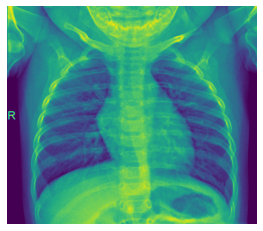

/tmp/chest_xray/train/NORMAL/NORMAL2-IM-1067-0001.jpeg


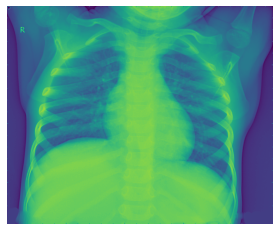

/tmp/chest_xray/train/PNEUMONIA/person768_bacteria_2672.jpeg


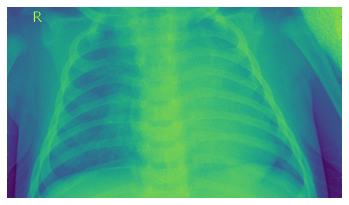

/tmp/chest_xray/train/PNEUMONIA/person270_virus_555.jpeg


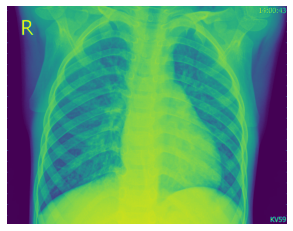

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

normal_files = os.listdir(normal_dir)

pneumonia_files = os.listdir(pneumonia_dir)

next_normal = [os.path.join(normal_dir, fname) 
                for fname in normal_files[pic_index-2:pic_index]]
next_pneumonia = [os.path.join(pneumonia_dir, fname) 
                for fname in pneumonia_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_normal+next_pneumonia):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [34]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/chest_xray/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/chest_xray/test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='binary',
  batch_size=20
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='binary',
  batch_size=20
)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:

history = model.fit(train_generator, epochs=50, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=8)

model.save("xray.h5")


Epoch 1/50
20/20 [==============================] - 34s 2s/step - loss: 0.1713 - accuracy: 0.9375 - val_loss: 0.3122 - val_accuracy: 0.9062
Epoch 2/50
20/20 [==============================] - 34s 2s/step - loss: 0.1709 - accuracy: 0.9300 - val_loss: 0.4028 - val_accuracy: 0.9062
Epoch 3/50
20/20 [==============================] - 34s 2s/step - loss: 0.1846 - accuracy: 0.9350 - val_loss: 1.0296 - val_accuracy: 0.7563
Epoch 4/50
20/20 [==============================] - 33s 2s/step - loss: 0.1978 - accuracy: 0.9175 - val_loss: 0.4316 - val_accuracy: 0.8819
Epoch 5/50
20/20 [==============================] - 33s 2s/step - loss: 0.2494 - accuracy: 0.9000 - val_loss: 0.3581 - val_accuracy: 0.8750
Epoch 6/50
20/20 [==============================] - 33s 2s/step - loss: 0.1696 - accuracy: 0.9275 - val_loss: 0.4328 - val_accuracy: 0.8438
Epoch 7/50
20/20 [==============================] - 34s 2s/step - loss: 0.1462 - accuracy: 0.9375 - val_loss: 0.7523 - val_accuracy: 0.7937
Epoch 8/50
20/20 [==

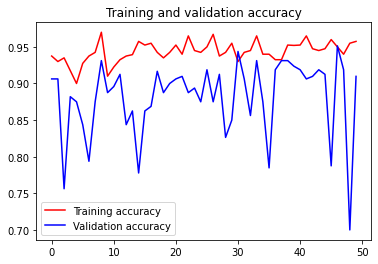

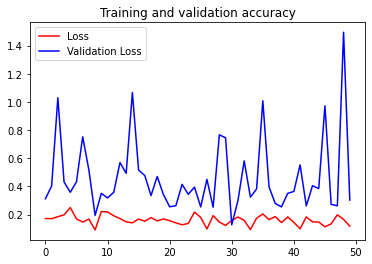

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()